In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications import *

from concurrent.futures import ThreadPoolExecutor
from gc import collect
from glob import glob
from tqdm.cli import tqdm

%matplotlib inline

In [37]:
ims = glob("./Training Images/*")

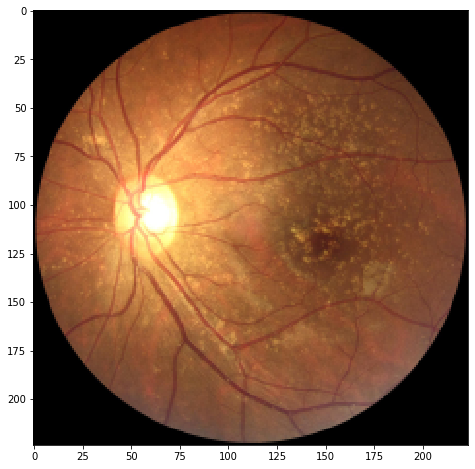

In [38]:
def crop_and_resize(im,):
    im_ = im.mean(axis=-1)
    ymin,*_,ymax = np.where(im_.sum(axis=1)>0)[0]
    xmin,*_,xmax = np.where(im_.sum(axis=0)>0)[0]
    
    im = im[ymin:ymax,xmin:xmax]
    im = cv2.resize(im,(224,224),interpolation=cv2.INTER_AREA)
    
    return im[:,:,::-1]

im = cv2.imread( np.random.choice(ims) )

plt.figure(figsize=(8,8))
plt.imshow(crop_and_resize(im))

In [39]:
# class Dataset(object):
#     def __init__(self,):
        
#         self.data = pd.read_csv("./data.csv")
#         self.data.columns = [col.replace(" ","_").lower() for col in  self.data.columns ]
#         self.dense_feat = self.data[['patient_age','patient_sex']].copy()

#         self.dense_feat['patient_age'] = self.dense_feat.patient_age / 100
#         self.dense_feat['patient_sex'] = self.dense_feat.patient_sex.apply( lambda x: int(x == 'Male') )

#         self.dense_feat = self.dense_feat.values.copy()
#         self.image_pairs = self.data[['left-fundus','right-fundus']].values

#         self.labels = self.data[["n","d","g","c","a","h","m","o",]].values


#     def read_data(self,):
        
#         self.images = np.zeros((len(self.image_pairs),2,224,224,3))
        
#         with tqdm(total=len(self.image_pairs)) as bar:
            
#             def read_image(args,):
#                 idx,(iml,imr) = args
#                 self.images[idx,0] = crop_and_resize(cv2.imread(f"./Training Images/{iml}"))
#                 self.images[idx,1] = crop_and_resize(cv2.imread(f"./Training Images/{imr}"))
#                 bar.update()
                
#             with ThreadPoolExecutor(max_workers=8) as executor:
#                 res = executor.map(read_image, enumerate(self.image_pairs))

# dataset = Dataset()        
# dataset.read_data()

# np.save("./images.npy",dataset.images.astype(np.uint8))
# np.save("./dense_features.npy",dataset.dense_feat)
# np.save("./labels.npy",dataset.labels)

In [40]:
class Dataset(object):
    def __init__(self,):
        self.classes = ["n","d","g","c","a","h","m","o",]
        
        self.labels = np.load("./labels.npy")
        self.dense_feat = np.load("./dense_features.npy")
        self.images = np.load("./images.npy")
        
        self.images = np.hstack((self.images[:,0],self.images[:,1]))

In [41]:
dataset = Dataset()

In [53]:
im_in = Input(shape=dataset.images[0].shape)
de_in = Input(shape=(2,))

net = MobileNet(input_tensor=im_in,include_top=False,weights='imagenet').output

out = GlobalAvgPool2D()(net)
out = concatenate([out,de_in])
out = Dense(len(dataset.labels[0]),use_bias=False,)(out)
out = BatchNormalization()(out)
out = Activation("softmax")(out)

model = Model([im_in,de_in],out)

In [55]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.00009),
    metrics=['categorical_accuracy']
)

In [58]:
model.fit(
    x = (dataset.images,dataset.dense_feat),
    y = dataset.labels,
    
    epochs=1,
    batch_size=16
)

219/219 [==============================] - 38s 173ms/step - loss: 0.9583 - categorical_accuracy: 0.8871


In [61]:
with open("./models/mobilenet/model.json","w+") as file:
    file.write(model.to_json())
    
model.save_weights("./models/mobilenet/model")

In [72]:
!zip "model.zip" "./models/mobilenet/*"

	zip warning: name not matched: ./models/mobilenet/*

zip error: Nothing to do! (model.zip)
